In [1]:
#%pylab inline
%matplotlib widget
%pylab
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as ss
import scipy.signal as sig
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle as Rectangle
import mpl_toolkits.mplot3d.art3d as art3d
import random
import matplotlib.lines as mlines

Using matplotlib backend: module://ipympl.backend_nbagg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys  
sys.path.insert(0, '/Users/JanviMadhani/satellite_planes')

import fortran_reader as fr
import plane_finding_tools as pf 

## Read Catalogs of Halos and Galaxies for all of New Horizon

In [3]:
filepath_nh = '/Users/JanviMadhani/Desktop/Satellite Galaxies/Analysis/New_Horizon/tree_bricks970'
haloes_nh = fr.ReadTreebrick_lowp(filepath_nh)


nbodies: [126492136] mpart: [1.3052102e-05] aexp: [0.82587326] omega_t: [0.39877856] age: [11.216812] nsub: [19209 10241] nhaloes: 29450
Reading haloes took 11.63 secs.
Total time was 11.64 secs.


In [4]:
haloes_nh_dict = haloes_nh.treebricks_dict

In [5]:
nhaloes = haloes_nh_dict['nhaloes']
halo_lbox_NH = haloes_nh_dict['lbox_NH']

In [6]:
z = lambda a:( 1-a)/a

In [7]:
filepath_catalog = '/Users/JanviMadhani/Desktop/Satellite Galaxies/Analysis/New_Horizon/tree_bricks970_stars_NH'
galaxies = fr.GalaxyCatalog(filepath_catalog)

nbodies: [337682774] mpart: [8.59259648e-08] aexp: [0.82587326] omega_t: [0.39877856] age: [11.21741055] nsub: [1186 4248] nmax: 5434
Reading galaxies took 96.67 secs.
Total time was 96.68 secs.


In [8]:
gal_nh_dict = galaxies.treebricks_dict

In [9]:
ngalaxies = gal_nh_dict['nmax']
gal_lbox_NH = gal_nh_dict['lbox_NH']

In [10]:
# extract info to plot

#first extract positions
halo_px = [haloes_nh_dict['haloes'][i]['px'] for i in range(nhaloes)]
halo_py = [haloes_nh_dict['haloes'][i]['py'] for i in range(nhaloes)]
halo_pz = [haloes_nh_dict['haloes'][i]['pz'] for i in range(nhaloes)]

halo_px = np.asarray(halo_px)
halo_py = np.asarray(halo_py)
halo_pz = np.asarray(halo_pz)


#then, constrain to 'zoom portion', which is radius of 20 Mpc
r = 10
halo_zoom = np.where(((-r < halo_px) & (halo_px < r )) & ((-r < halo_py) & (halo_py < r )) &
                      ((-r < halo_pz) & (halo_pz < r )))



halo_rvir = [haloes_nh_dict['haloes'][i]['rvir'] for i in range(nhaloes)]
halo_rvir = np.asarray(halo_rvir)
#print(np.max(halo_rvir[MW_type_haloes])*20)


#apply zoom masks
halo_px = halo_px[halo_zoom]
halo_py = halo_py[halo_zoom]
halo_pz = halo_pz[halo_zoom]
halo_rvir = halo_rvir[halo_zoom]

In [11]:
#look at where they are
gal_px = [gal_nh_dict['galaxies'][i]['px'] for i in range(ngalaxies)]
gal_py = [gal_nh_dict['galaxies'][i]['py'] for i in range(ngalaxies)]
gal_pz = [gal_nh_dict['galaxies'][i]['pz'] for i in range(ngalaxies)]

gal_px = np.asarray(gal_px)
gal_py = np.asarray(gal_py)
gal_pz = np.asarray(gal_pz)

gal_rvir = [gal_nh_dict['galaxies'][i]['rvir'] for i in range(ngalaxies)]
gal_rvir = np.asarray(gal_rvir)

# Read in already found systems

In [12]:
systems_file = '/Users/JanviMadhani/satellite_planes/systems/systems_970.pickle'
systems = pf.read_systems(systems_file)

Reading file from: /Users/JanviMadhani/satellite_planes/systems/systems_970.pickle


In [13]:
nsats_tot = []
for syst in systems:
    level1 = len(np.where(syst['sat_levels'] == 1)[0])
    nsats_tot.append(level1)

In [14]:
print(nsats_tot)
nsysts = len(nsats_tot)
print(nsysts)

[16, 60, 84, 104, 17, 104, 26, 21, 7, 32, 17, 7, 4, 2, 14]
15


## Look at all systems

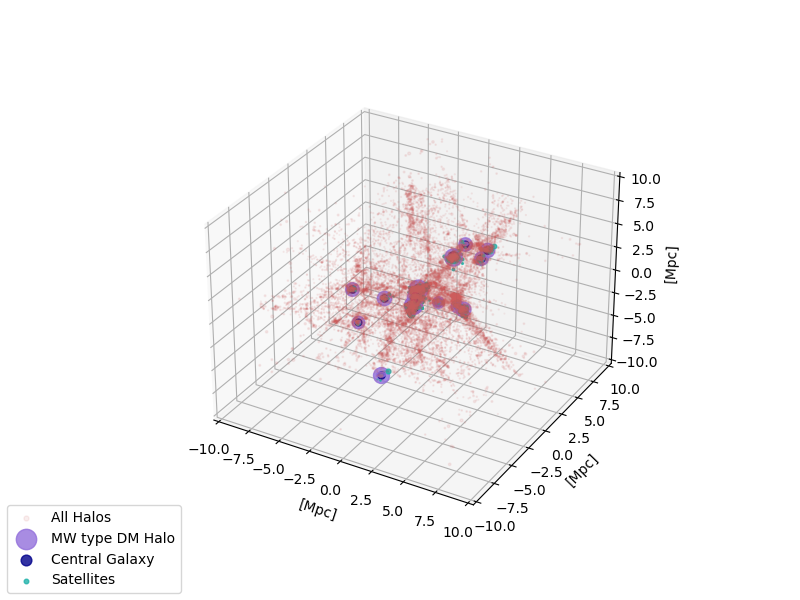

In [15]:
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection='3d')


M_to_k = 1
scaleby = 5
labels = ['All Halos','MW type DM Halo','Central Galaxy','Satellites',]


im1 = ax.scatter3D(halo_px*M_to_k,halo_py*M_to_k,halo_pz*M_to_k,
                      s=halo_rvir*M_to_k*scaleby**2,c='indianred',alpha=0.1,label=labels[0])



for syst in systems:
    scaleby = 20
    MW_x,MW_y,MW_z = syst['MW_px'],syst['MW_py'],syst['MW_pz']
    nsats = len(syst['sat_pxs'])
    level1 = len(np.where(syst['sat_levels'] == 1)[0])
    
    imhalo = ax.scatter3D((syst['halo_px'])*M_to_k,(syst['halo_py'])*M_to_k ,(syst['halo_pz'])*M_to_k,
                      s=syst['halo_rvir']*M_to_k*scaleby**2,c='mediumpurple',edgecolors='mediumpurple',alpha=0.8,label=labels[1])


    halo = Circle(((syst['halo_px'])*M_to_k, (syst['halo_py'])*M_to_k), radius=syst['halo_rvir']*M_to_k,color='mediumpurple',alpha=0.8)
    ax.add_patch(halo)
    art3d.pathpatch_2d_to_3d(halo, (syst['halo_pz'])*M_to_k, zdir="z")
    
    imcentral = ax.scatter3D((syst['MW_px'])*M_to_k,(syst['MW_py'])*M_to_k ,(syst['MW_pz'])*M_to_k,
                      s=syst['MW_rvir']*M_to_k*scaleby**2,c='darkblue',edgecolors='darkblue',alpha=0.8,label=labels[2])


    central = Circle(((syst['MW_px'])*M_to_k, (syst['MW_py'])*M_to_k), radius=syst['MW_rvir']*M_to_k,color='darkblue',alpha=0.8)
    ax.add_patch(central)
    art3d.pathpatch_2d_to_3d(central, (syst['MW_pz'])*M_to_k, zdir="z")
    



    for i in range(nsats):
        sat = Circle(((syst['sat_pxs'][i])*M_to_k, (syst['sat_pys'][i])*M_to_k), radius=syst['sat_rvirs'][i]*M_to_k,color='lightseagreen',alpha=0.8)
        ax.add_patch(sat)
        art3d.pathpatch_2d_to_3d(sat, (syst['sat_pzs'][i])*M_to_k, zdir="z")

        ax.scatter3D((syst['sat_pxs'][i])*M_to_k,(syst['sat_pys'][i])*M_to_k,(syst['sat_pzs'][i])*M_to_k,
                      s=syst['sat_rvirs'][i]*M_to_k*scaleby**2,c='lightseagreen',alpha=0.8,label=labels[3])

    
    


    
    handles, labs = ax.get_legend_handles_labels()


ax.set_xlabel('[Mpc]')
ax.set_ylabel('[Mpc]')
ax.set_zlabel('[Mpc]')

fig.legend(handles, labels, loc='lower left',markerscale = 1.5)


extent = 10 #Mpc
ax.set_xlim(-extent,extent)
ax.set_ylim(-extent,extent)
ax.set_zlim(-extent,extent)


plt.show()

## Pick a system

In [16]:
#analysis for one system
syst = 0

In [17]:

 
print('System with Halo ID:', systems[syst]['halo_ID'])
name_of_syst = systems[syst]['halo_ID']


best_u1,best_u2,best_u3,best_rms = pf.evolutionary_plane_finder(systems=systems,system=syst,n_iter=200,n_start=25,n_erase=10,n_avg_mutants=5,level=1,rand=False,verbose=True)
z_best,xx,yy,unit_n,los = pf.get_plane(u1=best_u1,u2=best_u2,u3=best_u3,systems=systems,system=syst)

#get physical extent, c_to_a:
a,b,c,phys_c_to_a = pf.find_physical_extent(u1=best_u1,u2=best_u2,u3=best_u3,systems=systems,system=syst,actual_rms=best_rms,nrms = 2,level=1)
phys_ext = [a,b,c,phys_c_to_a]

#find inertia tensor
I = pf.find_inertia_tensor(systems[syst])
v1,v2,v3 = pf.find_axes_of_rot(I)
i_c_to_a = pf.find_axes_ratios(I)

System with Halo ID: 1301
Fitting to 16 satellites...
best plane index: 250
Best plane has:
Cos(theta): 0.6224578679159978
Phi 1.807996655096704
u1 = 0.8112289339579989; u2 = 0.4640853959832766
Best rms = 0.08621199116375415


In [18]:
print('Position of galaxy:', [systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz']])
print('Radius',systems[syst]['MW_rvir'] )
print('Size of box to resimulate:', 6* np.array(systems[syst]['MW_rvir']))

Position of galaxy: [array([-2.89005374]), array([-3.91255851]), array([2.30813973])]
Radius [0.06635315]
Size of box to resimulate: [0.39811887]


In [19]:
projected_v = []
mvx,mvy,mvz = [systems[syst]['MW_vx'],systems[syst]['MW_vy'],systems[syst]['MW_vz']]
plos = np.array([unit_n[0],0,0])
#plos = v2
for i in range(len(systems[syst]['sat_vxs'])):
    svx,svy,svz = systems[syst]['sat_vxs'][i] - mvx, systems[syst]['sat_vys'][i] - mvy, systems[syst]['sat_vzs'][i] - mvz
    
    v = np.array([svx,svy,svz])
    v = v.flatten()
    #print(np.shape(v))
    #print(v)
    vx = pf.project_on_los(v,plos)
    
    projected_v.append(vx[0])
projected_v = np.asarray(projected_v)
#print(projected_v)

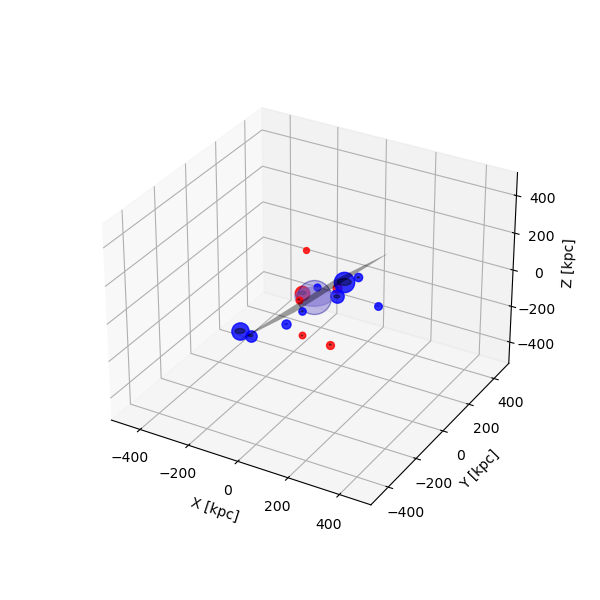

In [20]:
#quiver for spherical velocity

## Figure for presentation

#add some error to offset edge-on plane
randomize_theta = random.randint(-5,5)
randomize_phi = random.randint(-5,5)


fig = plt.figure(figsize=[6,6])
ax = plt.axes(projection='3d')
#ax.view_init(np.degrees(los[0])+randomize_theta,np.degrees(los[1])+randomize_phi)

M_to_k = 1000
MW_x,MW_y,MW_z = systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz']
nsats = len(systems[syst]['sat_pxs'])
level1 = len(np.where(systems[syst]['sat_levels'] == 1)[0])


scaleby = 3


for i in range(nsats):
    sat = Circle(((systems[syst]['sat_pxs'][i]-MW_x)*M_to_k, (systems[syst]['sat_pys'][i] - MW_y)*M_to_k), radius=systems[syst]['sat_rvirs'][i]*M_to_k,color='black',alpha=0.4)
    ax.add_patch(sat)
    art3d.pathpatch_2d_to_3d(sat, (systems[syst]['sat_pzs'][i]-MW_z)*M_to_k, zdir="z")
    #color = systems[syst]['sat_vxs'][i]-systems[syst]['MW_vx']
    color = projected_v[i]
    if color > 0:
        ax.scatter3D((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i]- MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                      s=systems[syst]['sat_rvirs'][i]*M_to_k*scaleby**2,c='blue',alpha=0.8)
        #velocity = ax.quiver((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i] - MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                             #v_rho[i],v_theta[i],v_z[i],1,color='orange', length= 1, normalize=False)

        #velocity_cart = ax.quiver((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i] - MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                                  #systems[syst]['sat_vxs'][i]-mvx,systems[syst]['sat_vys'][i]-mvy,systems[syst]['sat_vzs'][i]-mvz,color='black', length= 2, normalize=False)
    else:
        ax.scatter3D((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i]- MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                      s=systems[syst]['sat_rvirs'][i]*M_to_k*scaleby**2,c='red',alpha=0.8)
    
    
    

imcentral = ax.scatter3D((systems[syst]['MW_px']- MW_x)*M_to_k,(systems[syst]['MW_py']- MW_y)*M_to_k ,(systems[syst]['MW_pz'] - MW_z)*M_to_k,
                      s=systems[syst]['MW_rvir']*M_to_k*scaleby**2,c='slateblue',edgecolors='darkblue',alpha=0.4,label='Central')


central = Circle(((systems[syst]['MW_px'] - MW_x)*M_to_k, (systems[syst]['MW_py'] - MW_y)*M_to_k), radius=systems[syst]['MW_rvir']*M_to_k,color='slateblue',alpha=0.4,label='Rvir of MW')
ax.add_patch(central)
art3d.pathpatch_2d_to_3d(central, (systems[syst]['MW_pz']-MW_z)*M_to_k, zdir="z")

#plot the plane
plane = ax.plot_surface((xx-MW_x)*M_to_k,(yy-MW_y)*M_to_k, (z_best-MW_z)*M_to_k,color='k' ,alpha=0.4)




#ax.set_title(r'MW type Satellite System, $N_{sats}$ =' + f'{level1}',y=1.15)

ax.autoscale('False')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')


#"""
extent = 500 #kpc
ax.set_xlim(-extent,extent)
ax.set_ylim(-extent,extent)
ax.set_zlim(-extent,extent)
#"""

plt.show()


# Add the Filaments

In [21]:
skeleton_file_3 = '/Users/JanviMadhani/satellite_planes/outputs_infin/analysis_data/970/del_galaxy.NDnet_s3.up.NDskl.BRK.a.NDskl'
filaments_3 = fr.ReadFilament(skeleton_file_3)
filament_3_dict = filaments_3.filament_dict


skeleton_file_5 = '/Users/JanviMadhani/satellite_planes/outputs_infin/analysis_data/970/del_galaxy.NDnet_s5.up.NDskl.BRK.a.NDskl'
filaments_5 = fr.ReadFilament(skeleton_file_5)
filament_5_dict = filaments_5.filament_dict

skeleton_file_7 = '/Users/JanviMadhani/satellite_planes/outputs_infin/analysis_data/970/del_galaxy.NDnet_s7.up.NDskl.BRK.a.NDskl'
filaments_7 = fr.ReadFilament(skeleton_file_5)
filament_7_dict = filaments_5.filament_dict


header1, ANDSKEL

ndims, 3

Comments, #No comments (RB)

Bounding box, BBOX [-9.46958,-11.2398,-10.2952] [19.1849,19.2268,23.9453]

ncrit, 245
nfils, 185
Reading data fields:
CP field: persistence_ratio

CP field: persistence_nsigmas

CP field: persistence

CP field: persistence_pair

CP field: parent_index

CP field: parent_log_index

CP field: log_field_value

CP field: field_value

CP field: cell

Filament field: field_value

Filament field: orientation

Filament field: cell

Filament field: log_field_value

Filament field: type

Reading filaments took 0.03 secs.
header1, ANDSKEL

ndims, 3

Comments, #No comments (RB)

Bounding box, BBOX [-9.46958,-11.2398,-10.2952] [19.1849,19.2268,23.9453]

ncrit, 142
nfils, 90
Reading data fields:
CP field: persistence_ratio

CP field: persistence_nsigmas

CP field: persistence

CP field: persistence_pair

CP field: parent_index

CP field: parent_log_index

CP field: log_field_value

CP field: field_value

CP field: cell

Filament field: field_va

In [22]:
#redshift 1, persistence 5 filament

skeleton_file_z1 = '/Users/JanviMadhani/satellite_planes/outputs_infin/analysis_data/970/del_galaxy_z1.NDnet_s5.up.NDskl.BRK.a.NDskl'
filaments_z1 = fr.ReadFilament(skeleton_file_z1)
filament_z1_dict = filaments_z1.filament_dict

header1, ANDSKEL

ndims, 3

Comments, #No comments (RB)

Bounding box, BBOX [-4.91802,-6.76146,-5.81811] [10.1742,11.9152,12.607]

ncrit, 169
nfils, 117
Reading data fields:
CP field: persistence_ratio

CP field: persistence_nsigmas

CP field: persistence

CP field: persistence_pair

CP field: parent_index

CP field: parent_log_index

CP field: log_field_value

CP field: field_value

CP field: cell

Filament field: field_value

Filament field: orientation

Filament field: cell

Filament field: log_field_value

Filament field: type

Reading filaments took 0.01 secs.


In [23]:
print(filament_z1_dict.keys())
print(filament_z1_dict['filaments'][0].keys())

dict_keys(['ncrit', 'critical_points', 'nfils', 'filaments', 'nb_CP_fields', 'CP_fields', 'nb_fil_fields', 'fil_fields'])
dict_keys(['cp1_idx', 'cp2_idx', 'nsamp', 'px,py,pz', 'Field Vals'])


In [24]:
print(filament_z1_dict['filaments'][0])

{'cp1_idx': 15.0, 'cp2_idx': 16.0, 'nsamp': 2, 'px,py,pz': [[-2.23861, -1.29822, -1.4973], [-2.52808, -1.4283, -1.51951]], 'Field Vals': [31.39951, 1.0, 218.1, 1.561715, 2.0]}


In [25]:
#extract the CPs and fils


cp3_ID = [int(filament_3_dict['critical_points'][i]['pair_ID']) for i in range(filament_3_dict['ncrit'])]
cp3_px = [filament_3_dict['critical_points'][i]['px'] for i in range(filament_3_dict['ncrit'])]
cp3_py = [filament_3_dict['critical_points'][i]['py'] for i in range(filament_3_dict['ncrit'])]
cp3_pz = [filament_3_dict['critical_points'][i]['pz'] for i in range(filament_3_dict['ncrit'])]

cp3_ID = np.asarray(cp3_ID)
cp3_px = np.asarray(cp3_px)
cp3_py = np.asarray(cp3_py)
cp3_pz = np.asarray(cp3_pz)

cp5_ID = [int(filament_5_dict['critical_points'][i]['pair_ID']) for i in range(filament_5_dict['ncrit'])]
cp5_px = [filament_5_dict['critical_points'][i]['px'] for i in range(filament_5_dict['ncrit'])]
cp5_py = [filament_5_dict['critical_points'][i]['py'] for i in range(filament_5_dict['ncrit'])]
cp5_pz = [filament_5_dict['critical_points'][i]['pz'] for i in range(filament_5_dict['ncrit'])]

cp5_ID = np.asarray(cp5_ID)
cp5_px = np.asarray(cp5_px)
cp5_py = np.asarray(cp5_py)
cp5_pz = np.asarray(cp5_pz)


cp7_ID = [int(filament_7_dict['critical_points'][i]['pair_ID']) for i in range(filament_7_dict['ncrit'])]
cp7_px = [filament_7_dict['critical_points'][i]['px'] for i in range(filament_7_dict['ncrit'])]
cp7_py = [filament_7_dict['critical_points'][i]['py'] for i in range(filament_7_dict['ncrit'])]
cp7_pz = [filament_7_dict['critical_points'][i]['pz'] for i in range(filament_7_dict['ncrit'])]

cp7_ID = np.asarray(cp7_ID)
cp7_px = np.asarray(cp7_px)
cp7_py = np.asarray(cp7_py)
cp7_pz = np.asarray(cp7_pz)

nfils3 = int(filament_3_dict['nfils'])
nfils5 = int(filament_5_dict['nfils'])
nfils7 = int(filament_7_dict['nfils'])

In [26]:
#redshfit 1 params

cpz1_ID = [int(filament_z1_dict['critical_points'][i]['pair_ID']) for i in range(filament_z1_dict['ncrit'])]
cpz1_px = [filament_z1_dict['critical_points'][i]['px'] for i in range(filament_z1_dict['ncrit'])]
cpz1_py = [filament_z1_dict['critical_points'][i]['py'] for i in range(filament_z1_dict['ncrit'])]
cpz1_pz = [filament_z1_dict['critical_points'][i]['pz'] for i in range(filament_z1_dict['ncrit'])]

cpz1_ID = np.asarray(cpz1_ID)
cpz1_px = np.asarray(cpz1_px)
cpz1_py = np.asarray(cpz1_py)
cpz1_pz = np.asarray(cpz1_pz)

nfilsz1 = int(filament_z1_dict['nfils'])

In [32]:
def plot_filament(filament_idx,filament_dict,cp_ID,cp_px,cp_py,cp_pz,ax,scaleby=1000,highz=False,cp=True,colorcp='indigo',colorfil='slateblue'):
    
    cp1_idx = int(filament_dict['filaments'][filament_idx]['cp1_idx'])
    cp2_idx = int(filament_dict['filaments'][filament_idx]['cp2_idx'])
    
    nsamp = filament_dict['filaments'][filament_idx]['nsamp']
    
    positions = filament_dict['filaments'][filament_idx]['px,py,pz']
    
    cp1_ID = np.where((cp_ID == cp1_idx))
    cp2_ID = np.where((cp_ID == cp2_idx))
    
    
    if highz:
        cp1x,cp1y,cp1z = rescale_to_comoving(cp_px[cp1_ID],cp_py[cp1_ID],cp_pz[cp1_ID])
        cp2x,cp2y,cp2z = rescale_to_comoving(cp_px[cp2_ID],cp_py[cp2_ID],cp_pz[cp2_ID])
    else:
        cp1_positions = [cp_px[cp1_ID],cp_py[cp1_ID],cp_pz[cp1_ID]]
        cp2_positions = [cp_px[cp2_ID],cp_py[cp2_ID],cp_pz[cp2_ID]]
            
    
    
    #plot the two cp's first
    if cp:
    
        cp1 = ax.scatter3D(cp1_positions[0]*scaleby,cp1_positions[1]*scaleby,cp1_positions[2]*scaleby,
                           s=20,c=colorcp,alpha=0.4)
        cp2 = ax.scatter3D(cp2_positions[0]*scaleby,cp2_positions[1]*scaleby,cp2_positions[2]*scaleby,
                           s=20,c=colorcp,alpha=0.4)

    #plot the samples in between
    px = []
    py = []
    pz = []
    
    for i in range(nsamp):
        
        if highz:
            px1,py1,pz1 = rescale_to_comoving(positions[i][0],positions[i][1],positions[i][2])
        else:
            px1,py1,pz1 = positions[i][0],positions[i][1],positions[i][2]
            
        point = ax.scatter3D(px1*scaleby,py1*scaleby,pz1*scaleby,
                             s=5,c=colorfil,alpha=0.2)
        px.append(px1)
        py.append(py1)
        pz.append(pz1)
    
    fil_line = ax.plot(px*scaleby,py*scaleby,pz*scaleby,c=colorfil,lw = '10',alpha=0.2)

    
    
    
def plot_filament_wrt_syst(filament_idx,filament_dict,cp_ID,cp_px,cp_py,cp_pz,MW_x,MW_y,MW_z,ax,highz=False,scaleby=1000,cp=True,colorcp='teal',colorfil='teal'):
    
    """
    subtract off central position to center everything
    
    """
    
    
    cp1_idx = int(filament_dict['filaments'][filament_idx]['cp1_idx'])
    cp2_idx = int(filament_dict['filaments'][filament_idx]['cp2_idx'])
    
    nsamp = filament_dict['filaments'][filament_idx]['nsamp']
    
    positions = filament_dict['filaments'][filament_idx]['px,py,pz']
    
    cp1_ID = np.where((cp_ID == cp1_idx))
    cp2_ID = np.where((cp_ID == cp2_idx))
    
    cp1_positions = [cp_px[cp1_ID],cp_py[cp1_ID],cp_pz[cp1_ID]]
    cp2_positions = [cp_px[cp2_ID],cp_py[cp2_ID],cp_pz[cp2_ID]]
    
    
    #plot the two cp's first
    if cp:
    
        cp1 = ax.scatter3D((cp1_positions[0]- MW_x)*scaleby,(cp1_positions[1]- MW_y)*scaleby,(cp1_positions[2]- MW_z)*scaleby,
                           s=20,c=colorcp,alpha=0.4)
        cp2 = ax.scatter3D((cp2_positions[0]- MW_x)*scaleby,(cp2_positions[1]- MW_y)*scaleby,(cp2_positions[2]- MW_z)*scaleby,
                           s=20,c=colorcp,alpha=0.4)

    #plot the samples in between
    px = []
    py = []
    pz = []
    
    for i in range(nsamp):
        if highz:
            px1,py1,pz1 = rescale_to_comoving(positions[i][0],positions[i][1],positions[i][2])
        else:
            px1,py1,pz1 = positions[i][0],positions[i][1],positions[i][2]
            
        point = ax.scatter3D(px1*scaleby,py1*scaleby,pz1*scaleby,
                             s=5,c=colorfil,alpha=0.2)
        px.append(px1)
        py.append(py1)
        pz.append(pz1)
    
    fil_line = ax.plot((px- MW_x)*scaleby,(py- MW_y)*scaleby,(pz- MW_z)*scaleby,c=colorfil,lw = '10',alpha=0.2)
    
    
def rescale_to_comoving(px,py,pz):
    """
    Input: float, d1: starting size of box [Mpc]
           float, axep: current aexp 
    """
    
    
    H0 = 0.703000030517578e2
    h = H0/100 


    #lbox = d1/h #comoving distance (for physical, you multiply by aexp)
    #print('Comoving lbox',lbox)
    #lbox_current = lbox*aexp
    
    #print('Current lbox',lbox_current)
    
    
    #xco = px * lbox
    xco = px/h
    #xco += x_center
    
    #yco = py * lbox
    yco = py/h
    #yco += y_center
    
    #zco = pz * lbox
    zco = pz/h
    #zco += z_center


    
    return xco,yco,zco
    


In [29]:
positions = filament_z1_dict['filaments'][0]['px,py,pz']
nsamp = filament_z1_dict['filaments'][0]['nsamp']
for i in range(nsamp):
    px, py, pz = positions[i][0],positions[i][1],positions[i][2]
    print(px,py,pz)
    print('Comoving coord',rescale_to_comoving(px,py,pz))
    

-2.23861 -1.29822 -1.4973
Comoving coord (-3.184366860342583, -1.8466855528358885, -2.129871884781606)
-2.52808 -1.4283 -1.51951
Comoving coord (-3.596130711600001, -2.0317211066810708, -2.161465055529618)


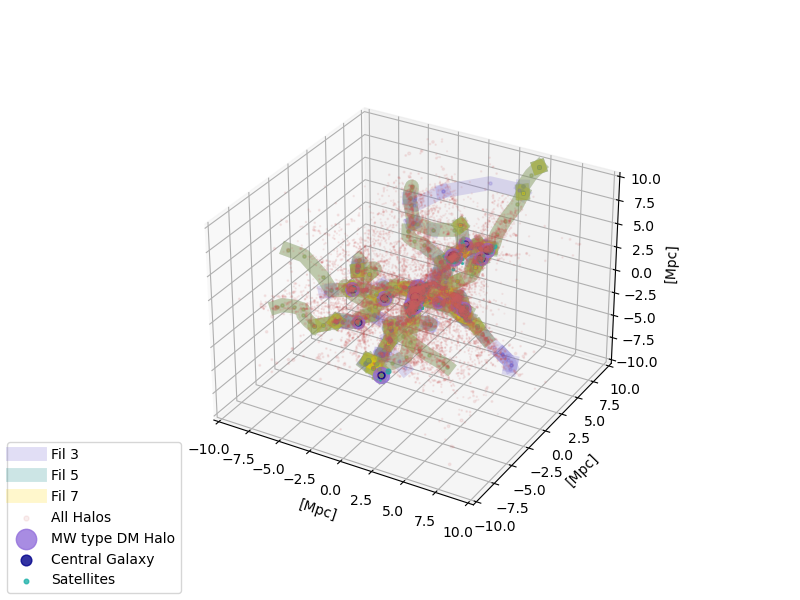

In [30]:
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection='3d')


M_to_k = 1
scaleby = 5
labels = ['Fil 3','Fil 5', 'Fil 7','All Halos','MW type DM Halo','Central Galaxy','Satellites',]

fil_colors = ['slateblue','teal','gold']
    
for j in range(nfils3):
    plot_filament(j,filament_3_dict,cp3_ID,cp3_px,cp3_py,cp3_pz,ax,scaleby=1,cp=False,colorfil=fil_colors[0])
    
for j in range(nfils5):
    plot_filament(j,filament_5_dict,cp5_ID,cp5_px,cp5_py,cp5_pz,ax,scaleby=1,cp=False,colorfil=fil_colors[1])
    
for j in range(nfils7):
    plot_filament(j,filament_7_dict,cp7_ID,cp7_px,cp7_py,cp7_pz,ax,scaleby=1,cp=False,colorfil=fil_colors[2])
    
fil3 = ax.plot3D([],[], [], color=fil_colors[0], lw = '10',alpha=0.2, label=labels[0])
    
fil5 = ax.plot3D([],[], [], color=fil_colors[1], lw = '10',alpha=0.2, label=labels[1])
    
fil7 = ax.plot3D([],[], [], color=fil_colors[2], lw = '10',alpha=0.2, label=labels[2])
    
    

im1 = ax.scatter3D(halo_px*M_to_k,halo_py*M_to_k,halo_pz*M_to_k,
                      s=halo_rvir*M_to_k*scaleby**2,c='indianred',alpha=0.1,label=labels[3])



for syst in systems:
    scaleby = 20
    MW_x,MW_y,MW_z = syst['MW_px'],syst['MW_py'],syst['MW_pz']
    nsats = len(syst['sat_pxs'])
    level1 = len(np.where(syst['sat_levels'] == 1)[0])
    
    imhalo = ax.scatter3D((syst['halo_px'])*M_to_k,(syst['halo_py'])*M_to_k ,(syst['halo_pz'])*M_to_k,
                      s=syst['halo_rvir']*M_to_k*scaleby**2,c='mediumpurple',edgecolors='mediumpurple',alpha=0.8,label=labels[4])


    halo = Circle(((syst['halo_px'])*M_to_k, (syst['halo_py'])*M_to_k), radius=syst['halo_rvir']*M_to_k,color='mediumpurple',alpha=0.8)
    ax.add_patch(halo)
    art3d.pathpatch_2d_to_3d(halo, (syst['halo_pz'])*M_to_k, zdir="z")
    
    imcentral = ax.scatter3D((syst['MW_px'])*M_to_k,(syst['MW_py'])*M_to_k ,(syst['MW_pz'])*M_to_k,
                      s=syst['MW_rvir']*M_to_k*scaleby**2,c='darkblue',edgecolors='darkblue',alpha=0.8,label=labels[5])


    central = Circle(((syst['MW_px'])*M_to_k, (syst['MW_py'])*M_to_k), radius=syst['MW_rvir']*M_to_k,color='darkblue',alpha=0.8)
    ax.add_patch(central)
    art3d.pathpatch_2d_to_3d(central, (syst['MW_pz'])*M_to_k, zdir="z")
    



    for i in range(nsats):
        sat = Circle(((syst['sat_pxs'][i])*M_to_k, (syst['sat_pys'][i])*M_to_k), radius=syst['sat_rvirs'][i]*M_to_k,color='lightseagreen',alpha=0.8)
        ax.add_patch(sat)
        art3d.pathpatch_2d_to_3d(sat, (syst['sat_pzs'][i])*M_to_k, zdir="z")

        ax.scatter3D((syst['sat_pxs'][i])*M_to_k,(syst['sat_pys'][i])*M_to_k,(syst['sat_pzs'][i])*M_to_k,
                      s=syst['sat_rvirs'][i]*M_to_k*scaleby**2,c='lightseagreen',alpha=0.8,label=labels[6])

    
    


    
    handles, labs = ax.get_legend_handles_labels()



ax.set_xlabel('[Mpc]')
ax.set_ylabel('[Mpc]')
ax.set_zlabel('[Mpc]')

fig.legend(handles, labels, loc='lower left',markerscale = 1.5)


extent = 10 #Mpc
ax.set_xlim(-extent,extent)
ax.set_ylim(-extent,extent)
ax.set_zlim(-extent,extent)


plt.show()

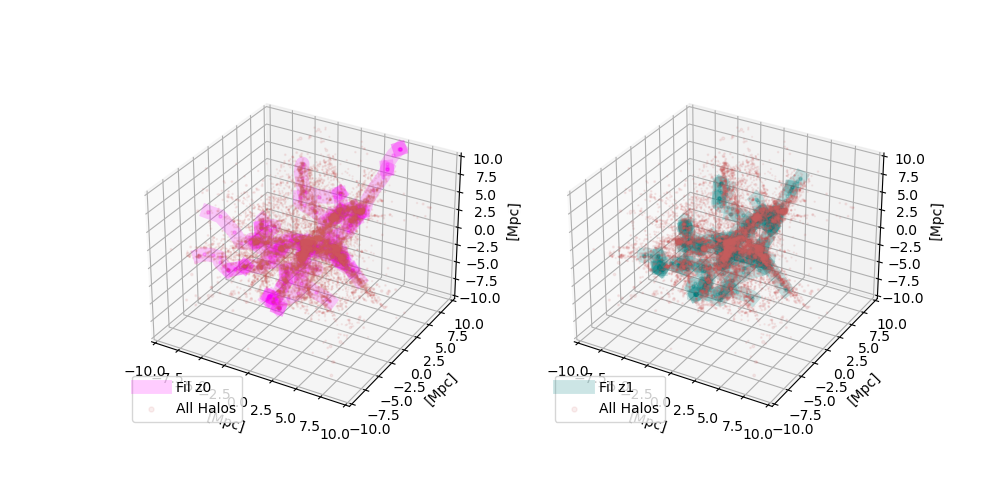

In [33]:
#redshift 1 and redshift ~0, filaments with persistance 5

fig = plt.figure(figsize=[10,5])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')


M_to_k = 1
scaleby = 5
labels_ax1 = ['Fil z0','All Halos']

fil_colors = ['magenta','teal']
    
    
for j in range(nfils5):
    plot_filament(j,filament_5_dict,cp5_ID,cp5_px,cp5_py,cp5_pz,ax1,scaleby=1,cp=False,colorfil=fil_colors[0])

fil5 = ax1.plot3D([],[], [], color=fil_colors[0], lw = '10',alpha=0.2, label=labels_ax1[0])

im1 = ax1.scatter3D(halo_px*M_to_k,halo_py*M_to_k,halo_pz*M_to_k,
                      s=halo_rvir*M_to_k*scaleby**2,c='indianred',alpha=0.1,label=labels_ax1[1])  
    

handles_ax1, labs1 = ax1.get_legend_handles_labels()
ax1.legend(handles_ax1, labs1, loc='lower left',markerscale = 1.5) 
ax1.set_xlabel('[Mpc]')
ax1.set_ylabel('[Mpc]')
ax1.set_zlabel('[Mpc]')


extent = 10 #Mpc
ax1.set_xlim(-extent,extent)
ax1.set_ylim(-extent,extent)
ax1.set_zlim(-extent,extent)


 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')


labels_ax2 = ['Fil z1','All Halos']
    
for j in range(nfilsz1):
    plot_filament(j,filament_z1_dict,cpz1_ID,cpz1_px,cpz1_py,cpz1_pz,ax2,scaleby=1,highz=True,cp=False,colorfil=fil_colors[1])
    

    
filz1 = ax2.plot3D([],[], [], color=fil_colors[1], lw = '10',alpha=0.2, label=labels_ax2[0])


im2 = ax2.scatter3D(halo_px*M_to_k,halo_py*M_to_k,halo_pz*M_to_k,
                      s=halo_rvir*M_to_k*scaleby**2,c='indianred',alpha=0.1,label=labels_ax2[1])

handles_ax2, labs2 = ax2.get_legend_handles_labels()

ax2.set_xlabel('[Mpc]')
ax2.set_ylabel('[Mpc]')
ax2.set_zlabel('[Mpc]')

ax2.legend(handles_ax2, labs2, loc='lower left',markerscale = 1.5)


extent = 10 #Mpc
ax2.set_xlim(-extent,extent)
ax2.set_ylim(-extent,extent)
ax2.set_zlim(-extent,extent)


plt.show()

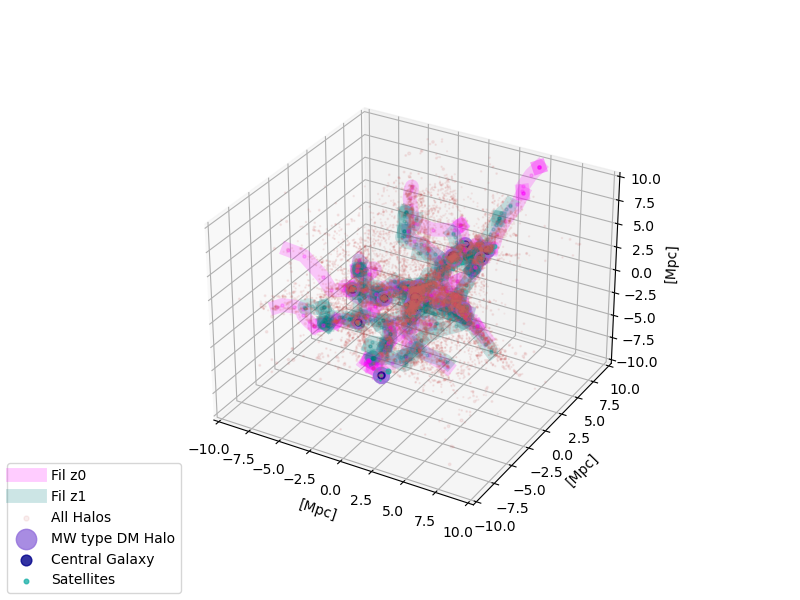

In [34]:
#redshift 1 and redshift ~0, filaments with persistance 5

fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection='3d')


M_to_k = 1
scaleby = 5
labels = ['Fil z0','Fil z1','All Halos','MW type DM Halo','Central Galaxy','Satellites',]

fil_colors = ['magenta','teal']
    
    
for j in range(nfils5):
    plot_filament(j,filament_5_dict,cp5_ID,cp5_px,cp5_py,cp5_pz,ax,scaleby=1,cp=False,colorfil=fil_colors[0])
    
for j in range(nfilsz1):
    plot_filament(j,filament_z1_dict,cpz1_ID,cpz1_px,cpz1_py,cpz1_pz,ax,scaleby=1,highz=True,cp=False,colorfil=fil_colors[1])
    
fil5 = ax.plot3D([],[], [], color=fil_colors[0], lw = '10',alpha=0.2, label=labels[0])
    
filz1 = ax.plot3D([],[], [], color=fil_colors[1], lw = '10',alpha=0.2, label=labels[1])

    
    

im1 = ax.scatter3D(halo_px*M_to_k,halo_py*M_to_k,halo_pz*M_to_k,
                      s=halo_rvir*M_to_k*scaleby**2,c='indianred',alpha=0.1,label=labels[2])



for syst in systems:
    scaleby = 20
    MW_x,MW_y,MW_z = syst['MW_px'],syst['MW_py'],syst['MW_pz']
    nsats = len(syst['sat_pxs'])
    level1 = len(np.where(syst['sat_levels'] == 1)[0])
    
    imhalo = ax.scatter3D((syst['halo_px'])*M_to_k,(syst['halo_py'])*M_to_k ,(syst['halo_pz'])*M_to_k,
                      s=syst['halo_rvir']*M_to_k*scaleby**2,c='mediumpurple',edgecolors='mediumpurple',alpha=0.8,label=labels[3])


    halo = Circle(((syst['halo_px'])*M_to_k, (syst['halo_py'])*M_to_k), radius=syst['halo_rvir']*M_to_k,color='mediumpurple',alpha=0.8)
    ax.add_patch(halo)
    art3d.pathpatch_2d_to_3d(halo, (syst['halo_pz'])*M_to_k, zdir="z")
    
    imcentral = ax.scatter3D((syst['MW_px'])*M_to_k,(syst['MW_py'])*M_to_k ,(syst['MW_pz'])*M_to_k,
                      s=syst['MW_rvir']*M_to_k*scaleby**2,c='darkblue',edgecolors='darkblue',alpha=0.8,label=labels[4])


    central = Circle(((syst['MW_px'])*M_to_k, (syst['MW_py'])*M_to_k), radius=syst['MW_rvir']*M_to_k,color='darkblue',alpha=0.8)
    ax.add_patch(central)
    art3d.pathpatch_2d_to_3d(central, (syst['MW_pz'])*M_to_k, zdir="z")
    



    for i in range(nsats):
        sat = Circle(((syst['sat_pxs'][i])*M_to_k, (syst['sat_pys'][i])*M_to_k), radius=syst['sat_rvirs'][i]*M_to_k,color='lightseagreen',alpha=0.8)
        ax.add_patch(sat)
        art3d.pathpatch_2d_to_3d(sat, (syst['sat_pzs'][i])*M_to_k, zdir="z")

        ax.scatter3D((syst['sat_pxs'][i])*M_to_k,(syst['sat_pys'][i])*M_to_k,(syst['sat_pzs'][i])*M_to_k,
                      s=syst['sat_rvirs'][i]*M_to_k*scaleby**2,c='lightseagreen',alpha=0.8,label=labels[5])

    
    


    
    handles, labs = ax.get_legend_handles_labels()



ax.set_xlabel('[Mpc]')
ax.set_ylabel('[Mpc]')
ax.set_zlabel('[Mpc]')

fig.legend(handles, labels, loc='lower left',markerscale = 1.5)


extent = 10 #Mpc
ax.set_xlim(-extent,extent)
ax.set_ylim(-extent,extent)
ax.set_zlim(-extent,extent)


plt.show()

### Analysis functions

In [35]:

def distance(p1,p2):
    """
    Input: list, p1: [r1,r2,r3]
           list, p2: [r1,r2,r3]
    Returns: float, scalar distance
    """
    
    x1,y1,z1 = p1[0],p1[1],p1[2]
    x2,y2,z2 = p2[0],p2[1],p2[2]
    
    dist = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    
    return dist


def nearest_fil(gal_pos,filament_dict,highz=False,nnear=3):
    
    """
    Input: list,gal_pos: [MW_x,MW_y,MW_z], coordinates of central galaxy 
           dict,filament_dict: dictionary of filaments
    """
    MW_x, MW_y, MW_z = gal_pos[0],gal_pos[1],gal_pos[2]
    
    nfils = int(filament_dict['nfils'])
    
    closest_fil_idx = []
    
    min_fil_dist = []
    
    for i in range(nfils):
        
        #look for min distance to sampling point of fil
 
        distances = []
    
        filament_idx = i 
    
        nsamp = filament_dict['filaments'][filament_idx]['nsamp']
        
        if highz:
            px,py,pz = filament_dict['filaments'][filament_idx]['px,py,pz']
            pxc,pyc,pzc = rescale_to_comoving(px,py,pz)
            
            positions = [pxc,pyc,pzc]
        else:   
            positions = filament_dict['filaments'][filament_idx]['px,py,pz']
        
        for i in range(nsamp):
    
            dist_to_samp = distance([MW_x,MW_y,MW_z],positions[i])
            distances.append(dist_to_samp)
            
        distances = np.asarray(distances)
        min_dist_to_sample = np.min(distances)
        
        min_fil_dist.append(min_dist_to_sample)
        
   
    min_fil_dist = np.asarray(min_fil_dist)
    #nearest_fil_idx = np.argmin(min_fil_dist)
    nearest_fil_idx = np.argpartition(min_fil_dist,nnear)
    
    closest_fils = nearest_fil_idx[:nnear]
    
    return closest_fils

        
        
    

In [36]:
syst = 0
gal_pos = [systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz']]
nearest_fils_to_syst_z0 = nearest_fil(gal_pos,filament_5_dict,nnear=4)
print(nearest_fils_to_syst_z0)

nearest_fils_to_syst_z1 = nearest_fil(gal_pos,filament_z1_dict,nnear=4)
print(nearest_fils_to_syst_z1)

[25  5  3 87]
[ 96  58  95 107  57 100]


# Plot system and Filament

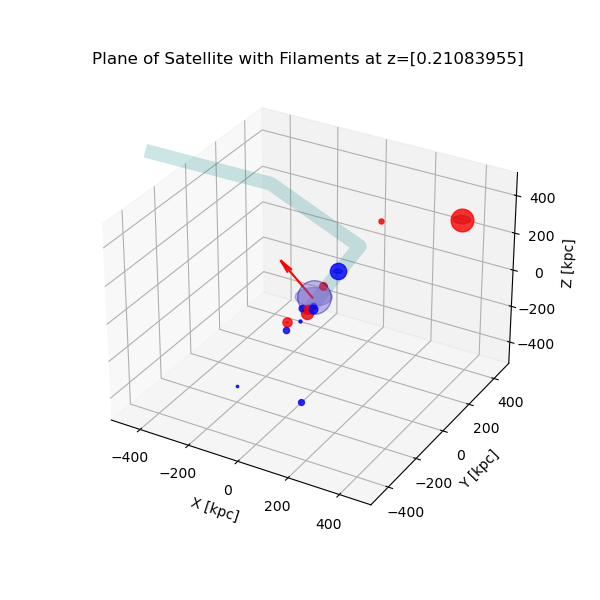

In [111]:
#quiver for spherical velocity

## Figure for presentation

z0 = z(gal_nh_dict['aexp'])
#add some error to offset edge-on plane
randomize_theta = random.randint(-5,5)
randomize_phi = random.randint(-5,5)


fig = plt.figure(figsize=[6,6])
ax = plt.axes(projection='3d')
#ax.view_init(np.degrees(los[0])+randomize_theta,np.degrees(los[1])+randomize_phi)

M_to_k = 1000
MW_x,MW_y,MW_z = systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz']
nsats = len(systems[syst]['sat_pxs'])
level1 = len(np.where(systems[syst]['sat_levels'] == 1)[0])


scaleby = 3

#plot nearest fil to system
for fil_idx in nearest_fils_to_syst_z0:
    plot_filament_wrt_syst(fil_idx,filament_5_dict,cp5_ID,cp5_px,cp5_py,cp5_pz,MW_x,MW_y,MW_z,ax,scaleby=M_to_k,cp=False)
    #plot_filament_wrt_syst(fil_idx,filament_3_dict,cp3_ID,cp3_px,cp3_py,cp3_pz,MW_x,MW_y,MW_z,ax,scaleby=M_to_k,cp=False)


for i in range(nsats):
    sat = Circle(((systems[syst]['sat_pxs'][i]-MW_x)*M_to_k, (systems[syst]['sat_pys'][i] - MW_y)*M_to_k), radius=systems[syst]['sat_rvirs'][i]*M_to_k,color='black',alpha=0.4)
    ax.add_patch(sat)
    art3d.pathpatch_2d_to_3d(sat, (systems[syst]['sat_pzs'][i]-MW_z)*M_to_k, zdir="z")
    #color = systems[syst]['sat_vxs'][i]-systems[syst]['MW_vx']
    color = projected_v[i]
    if color > 0:
        ax.scatter3D((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i]- MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                      s=systems[syst]['sat_rvirs'][i]*M_to_k*scaleby**2,c='blue',alpha=0.8)
        #velocity = ax.quiver((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i] - MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                             #v_rho[i],v_theta[i],v_z[i],1,color='orange', length= 1, normalize=False)

        #velocity_cart = ax.quiver((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i] - MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                                  #systems[syst]['sat_vxs'][i]-mvx,systems[syst]['sat_vys'][i]-mvy,systems[syst]['sat_vzs'][i]-mvz,color='black', length= 2, normalize=False)
    else:
        ax.scatter3D((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i]- MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                      s=systems[syst]['sat_rvirs'][i]*M_to_k*scaleby**2,c='red',alpha=0.8)
    
    
    

imcentral = ax.scatter3D((systems[syst]['MW_px']- MW_x)*M_to_k,(systems[syst]['MW_py']- MW_y)*M_to_k ,(systems[syst]['MW_pz'] - MW_z)*M_to_k,
                      s=systems[syst]['MW_rvir']*M_to_k*scaleby**2,c='slateblue',edgecolors='darkblue',alpha=0.4,label='Central')


central = Circle(((systems[syst]['MW_px'] - MW_x)*M_to_k, (systems[syst]['MW_py'] - MW_y)*M_to_k), radius=systems[syst]['MW_rvir']*M_to_k,color='slateblue',alpha=0.4,label='Rvir of MW')
ax.add_patch(central)
art3d.pathpatch_2d_to_3d(central, (systems[syst]['MW_pz']-MW_z)*M_to_k, zdir="z")

#plot the plane
plane = ax.plot_surface((xx-MW_x)*M_to_k,(yy-MW_y)*M_to_k, (z_best-MW_z)*M_to_k,color='k' ,alpha=0.4)

#plot the normal vector of the plane

normal = ax.quiver(systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz'],
                       unit_n[0],unit_n[1],unit_n[2],color='red', length=200, normalize=True,label='Normal')




#ax.set_title(r'MW type Satellite System, $N_{sats}$ =' + f'{level1}',y=1.15)

ax.autoscale('False')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')


#"""
extent = 500 #kpc
ax.set_xlim(-extent,extent)
ax.set_ylim(-extent,extent)
ax.set_zlim(-extent,extent)
#"""

ax.set_title(f'Plane of Satellite with Filaments at z={z0}')

plt.show()


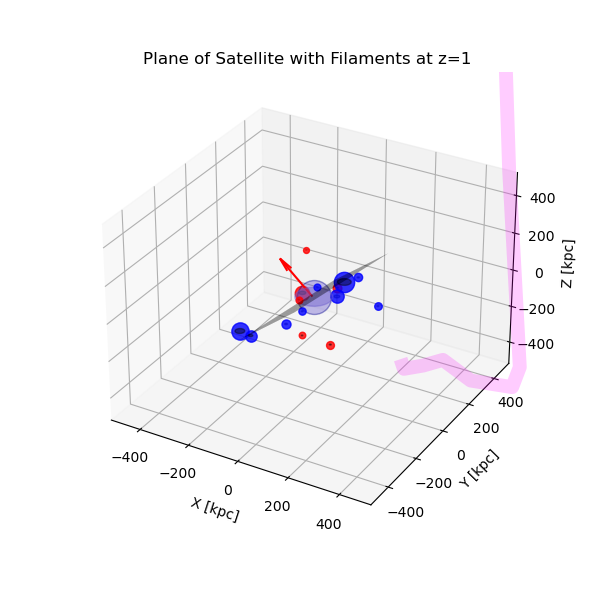

In [38]:
#quiver for spherical velocity

## Figure for presentation

#add some error to offset edge-on plane
randomize_theta = random.randint(-5,5)
randomize_phi = random.randint(-5,5)


fig = plt.figure(figsize=[6,6])
ax = plt.axes(projection='3d')
#ax.view_init(np.degrees(los[0])+randomize_theta,np.degrees(los[1])+randomize_phi)

M_to_k = 1000
MW_x,MW_y,MW_z = systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz']
nsats = len(systems[syst]['sat_pxs'])
level1 = len(np.where(systems[syst]['sat_levels'] == 1)[0])


scaleby = 3

#plot nearest fil to system


for fil_idx in nearest_fils_to_syst_z1:
    plot_filament_wrt_syst(fil_idx,filament_z1_dict,cp5_ID,cp5_px,cp5_py,cp5_pz,MW_x,MW_y,MW_z,ax,highz=True,scaleby=M_to_k,cp=False,colorfil='magenta')
    #plot_filament_wrt_syst(fil_idx,filament_3_dict,cp3_ID,cp3_px,cp3_py,cp3_pz,MW_x,MW_y,MW_z,ax,scaleby=M_to_k,cp=False)


for i in range(nsats):
    sat = Circle(((systems[syst]['sat_pxs'][i]-MW_x)*M_to_k, (systems[syst]['sat_pys'][i] - MW_y)*M_to_k), radius=systems[syst]['sat_rvirs'][i]*M_to_k,color='black',alpha=0.4)
    ax.add_patch(sat)
    art3d.pathpatch_2d_to_3d(sat, (systems[syst]['sat_pzs'][i]-MW_z)*M_to_k, zdir="z")
    #color = systems[syst]['sat_vxs'][i]-systems[syst]['MW_vx']
    color = projected_v[i]
    if color > 0:
        ax.scatter3D((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i]- MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                      s=systems[syst]['sat_rvirs'][i]*M_to_k*scaleby**2,c='blue',alpha=0.8)
        #velocity = ax.quiver((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i] - MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                             #v_rho[i],v_theta[i],v_z[i],1,color='orange', length= 1, normalize=False)

        #velocity_cart = ax.quiver((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i] - MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                                  #systems[syst]['sat_vxs'][i]-mvx,systems[syst]['sat_vys'][i]-mvy,systems[syst]['sat_vzs'][i]-mvz,color='black', length= 2, normalize=False)
    else:
        ax.scatter3D((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i]- MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                      s=systems[syst]['sat_rvirs'][i]*M_to_k*scaleby**2,c='red',alpha=0.8)
    
    
    

imcentral = ax.scatter3D((systems[syst]['MW_px']- MW_x)*M_to_k,(systems[syst]['MW_py']- MW_y)*M_to_k ,(systems[syst]['MW_pz'] - MW_z)*M_to_k,
                      s=systems[syst]['MW_rvir']*M_to_k*scaleby**2,c='slateblue',edgecolors='darkblue',alpha=0.4,label='Central')


central = Circle(((systems[syst]['MW_px'] - MW_x)*M_to_k, (systems[syst]['MW_py'] - MW_y)*M_to_k), radius=systems[syst]['MW_rvir']*M_to_k,color='slateblue',alpha=0.4,label='Rvir of MW')
ax.add_patch(central)
art3d.pathpatch_2d_to_3d(central, (systems[syst]['MW_pz']-MW_z)*M_to_k, zdir="z")

#plot the plane
plane = ax.plot_surface((xx-MW_x)*M_to_k,(yy-MW_y)*M_to_k, (z_best-MW_z)*M_to_k,color='k' ,alpha=0.4)
normal = ax.quiver(systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz'],
                       unit_n[0],unit_n[1],unit_n[2],color='red', length=200, normalize=True,label='Normal')




#ax.set_title(r'MW type Satellite System, $N_{sats}$ =' + f'{level1}',y=1.15)

ax.autoscale('False')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')


#"""
extent = 500 #kpc
ax.set_xlim(-extent,extent)
ax.set_ylim(-extent,extent)
ax.set_zlim(-extent,extent)
#"""

ax.set_title('Plane of Satellite with Filaments at z=1')

plt.show()


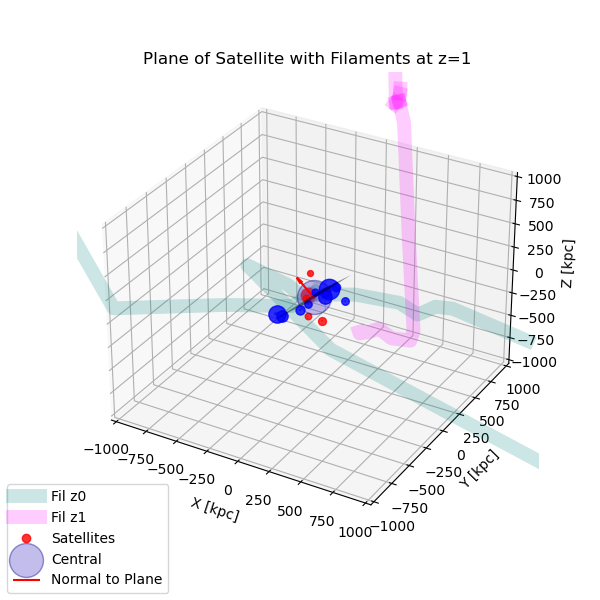

In [39]:
# look at both filaments together

#quiver for spherical velocity

## Figure for presentation

#add some error to offset edge-on plane
randomize_theta = random.randint(-5,5)
randomize_phi = random.randint(-5,5)

labels= ['Fil z0', 'Fil z1', 'Central', 'Satellites']


fig = plt.figure(figsize=[6,6])
ax = plt.axes(projection='3d')
#ax.view_init(np.degrees(los[0])+randomize_theta,np.degrees(los[1])+randomize_phi)

M_to_k = 1000
MW_x,MW_y,MW_z = systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz']
nsats = len(systems[syst]['sat_pxs'])
level1 = len(np.where(systems[syst]['sat_levels'] == 1)[0])


scaleby = 3

#plot nearest fil to system

for fil_idx in nearest_fils_to_syst_z0:
    plot_filament_wrt_syst(fil_idx,filament_5_dict,cp5_ID,cp5_px,cp5_py,cp5_pz,MW_x,MW_y,MW_z,ax,scaleby=M_to_k,cp=False)

for fil_idx in nearest_fils_to_syst_z1:
    plot_filament_wrt_syst(fil_idx,filament_z1_dict,cp5_ID,cp5_px,cp5_py,cp5_pz,MW_x,MW_y,MW_z,ax,highz=True,scaleby=M_to_k,cp=False,colorfil='magenta')
    #plot_filament_wrt_syst(fil_idx,filament_3_dict,cp3_ID,cp3_px,cp3_py,cp3_pz,MW_x,MW_y,MW_z,ax,scaleby=M_to_k,cp=False)


fil5 = ax.plot3D([],[], [], color='teal', lw = '10',alpha=0.2, label=labels[0])
    
filz1 = ax.plot3D([],[], [], color='magenta', lw = '10',alpha=0.2, label=labels[1])
    
for i in range(nsats):
    sat = Circle(((systems[syst]['sat_pxs'][i]-MW_x)*M_to_k, (systems[syst]['sat_pys'][i] - MW_y)*M_to_k), radius=systems[syst]['sat_rvirs'][i]*M_to_k,color='black',alpha=0.4)
    ax.add_patch(sat)
    art3d.pathpatch_2d_to_3d(sat, (systems[syst]['sat_pzs'][i]-MW_z)*M_to_k, zdir="z")
    #color = systems[syst]['sat_vxs'][i]-systems[syst]['MW_vx']
    color = projected_v[i]
    if color > 0:
        ax.scatter3D((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i]- MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                      s=systems[syst]['sat_rvirs'][i]*M_to_k*scaleby**2,c='blue',alpha=0.8)
        #velocity = ax.quiver((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i] - MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                             #v_rho[i],v_theta[i],v_z[i],1,color='orange', length= 1, normalize=False)

        #velocity_cart = ax.quiver((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i] - MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                                  #systems[syst]['sat_vxs'][i]-mvx,systems[syst]['sat_vys'][i]-mvy,systems[syst]['sat_vzs'][i]-mvz,color='black', length= 2, normalize=False)
    else:
        ax.scatter3D((systems[syst]['sat_pxs'][i] - MW_x)*M_to_k,(systems[syst]['sat_pys'][i]- MW_y)*M_to_k,(systems[syst]['sat_pzs'][i] - MW_z)*M_to_k,
                      s=systems[syst]['sat_rvirs'][i]*M_to_k*scaleby**2,c='red',alpha=0.8)
    
imcentral = ax.scatter3D((systems[syst]['MW_px']- MW_x)*M_to_k,(systems[syst]['MW_py']- MW_y)*M_to_k ,(systems[syst]['MW_pz'] - MW_z)*M_to_k,
                      s=systems[syst]['MW_rvir']*M_to_k*scaleby**2,c='slateblue',edgecolors='darkblue',alpha=0.4,label=labels[2])


central = Circle(((systems[syst]['MW_px'] - MW_x)*M_to_k, (systems[syst]['MW_py'] - MW_y)*M_to_k), radius=systems[syst]['MW_rvir']*M_to_k,color='slateblue',alpha=0.4)
ax.add_patch(central)
art3d.pathpatch_2d_to_3d(central, (systems[syst]['MW_pz']-MW_z)*M_to_k, zdir="z")

#plot the plane
plane = ax.plot_surface((xx-MW_x)*M_to_k,(yy-MW_y)*M_to_k, (z_best-MW_z)*M_to_k,color='k' ,alpha=0.4)
normal = ax.quiver(systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz'],
                       unit_n[0],unit_n[1],unit_n[2],color='red', length=200, normalize=True,label='Normal to Plane')

#satellite proxy

sat_proxy = ax.plot3D([],[],[],marker='o',ls=' ',c='red',alpha=0.8,label=labels[3])


#ax.set_title(r'MW type Satellite System, $N_{sats}$ =' + f'{level1}',y=1.15)

ax.autoscale('False')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')


#"""
extent = 1000 #kpc
ax.set_xlim(-extent,extent)
ax.set_ylim(-extent,extent)
ax.set_zlim(-extent,extent)
#"""

ax.set_title('Plane of Satellite with Filaments at z=1')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left')

plt.show()


In [85]:
def plane_angular_sep_from_fil(filament_idx,filament_dict,u1,u2,u3,highz=False):
    """
    Input: integer, fil_idx: index of filament you want distance to 
           dict, fil_dict: dictionary of filament
           floats,u1,u2,u3: to calculate the normal vector of plane
           boolean,highz: rescales to comoving cord if evaluating at high z 
    Returns:
           float, theta: angular sep between filament and normal vector of plane 
    
    """
    
    #normal vector of best plane
    #calc relevant angles 
    
    cos_theta = 2*u1 - 1   #makes sure cos_phi is bw 0,1

    sin_theta = np.sqrt(1-cos_theta**2)
    #randomly select sign of arccos 

    if u3 <= 0.5:
        sin_theta = -1*sin_theta


    phi = 2*np.pi*u2  #[-pi,pi]  

    nx = np.cos(phi)*sin_theta
    ny = np.sin(phi)*sin_theta
    nz = cos_theta
    normal = np.array([nx,ny,nz])
    

    
    
    
    
    nsamp = filament_dict['filaments'][filament_idx]['nsamp']
    
    positions = filament_dict['filaments'][filament_idx]['px,py,pz']
    
    px = []
    py = []
    pz = []
    
    for i in range(nsamp):
        if highz:
            px1,py1,pz1 = rescale_to_comoving(positions[i][0],positions[i][1],positions[i][2])
        else:
            px1,py1,pz1 = positions[i][0],positions[i][1],positions[i][2]
            
        px.append(px1)
        py.append(py1)
        pz.append(pz1)
            
    
    fil_vector = np.array([px[1]-px[0],py[1]-py[0],pz[1]-pz[0]])
    
    dot_prod = np.dot(fil_vector,normal)
    mag_fil_vec = np.linalg.norm(fil_vector)
    mag_normal = np.linalg.norm(normal)
   
    
    angle_sep = np.arccos(dot_prod/(mag_fil_vec*mag_normal))
    angle_sep = np.degrees(angle_sep)
    
    #check that it's between 0 - 90
    
    if 0 < angle_sep < 90:
        return angle_sep
    
    else:
        
        return abs(angle_sep-90)
    




In [86]:
nearest_fils_to_syst_z0 = nearest_fil(gal_pos,filament_5_dict,nnear=1)
print(nearest_fils_to_syst_z0)

nearest_fils_to_syst_z1 = nearest_fil(gal_pos,filament_z1_dict,nnear=1)
print(nearest_fils_to_syst_z1)

[21]
[80]


In [87]:
print('ang sep from closest fil at z0:',plane_angular_sep_from_fil(25,filament_5_dict,best_u1,best_u2,best_u3))
print('ang sep from closest fil at z0:',plane_angular_sep_from_fil(58,filament_z1_dict,best_u1,best_u2,best_u3))

ang sep from closest fil at z0: 3.692528067307332
ang sep from closest fil at z0: 54.39715831461265


In [125]:
#systems_to_analyze = [0,4,6,7,8,9,11,14] #best planes
systems_to_analyze = [i for i in range(15)]

ang_sep_z0 = []
ang_sep_z1 = []
rms = []

for syst in systems_to_analyze:
    gal_pos = [systems[syst]['MW_px'],systems[syst]['MW_py'],systems[syst]['MW_pz']]
    nearest_fil_to_syst_z0 = nearest_fil(gal_pos,filament_5_dict,nnear=1)
    nearest_fil_to_syst_z1 = nearest_fil(gal_pos,filament_z1_dict,nnear=1)
    nearest_fil_to_syst_z0 = int(nearest_fil_to_syst_z0)
    nearest_fil_to_syst_z1 = int(nearest_fil_to_syst_z1)
    best_u1,best_u2,best_u3,best_rms = pf.evolutionary_plane_finder(systems=systems,system=syst,n_iter=200,n_start=25,n_erase=10,n_avg_mutants=5,level=1,rand=False,verbose=False)
    ang_sep_z0.append(plane_angular_sep_from_fil(nearest_fil_to_syst_z0,filament_5_dict,best_u1,best_u2,best_u3))
    ang_sep_z1.append(plane_angular_sep_from_fil(nearest_fil_to_syst_z1,filament_z1_dict,best_u1,best_u2,best_u3))
    rms.append(best_rms)
    

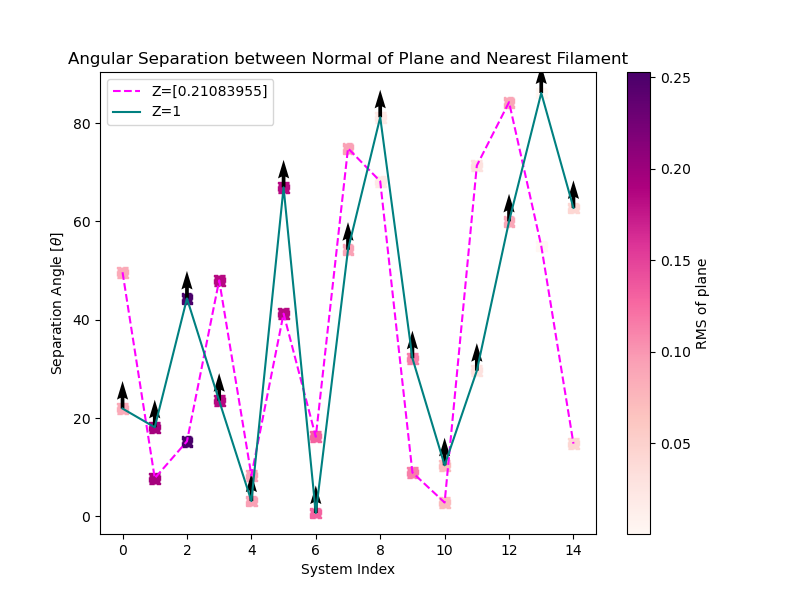

In [141]:


fig,ax = plt.subplots(figsize=[8,6])



z_0 = ax.plot(systems_to_analyze, ang_sep_z0, ls='--',color='magenta',label=f'Z={z0}')
z0_c = ax.scatter(systems_to_analyze, ang_sep_z0, marker='s',s=60,ls='--',c=rms,cmap='RdPu')

z_1 = ax.plot(systems_to_analyze, ang_sep_z1,ls='-',color='teal',label='Z=1')
z1_c = ax.scatter(systems_to_analyze, ang_sep_z1, s=60,marker='s',ls='--',c=rms,cmap='RdPu')


#add arrows

directions = []

for i in range(len(sytems_to_analyze)):
    plus_minus = ang_sep_z1[i] - ang_sep_z0[i]
    
    if plus

for ang in range(len(systems_to_analyze)):
    ax.quiver(systems_to_analyze[ang], ang_sep_z1[ang],0, ang_sep_z0[ang],pivot='tail')


ax.set_xlabel('System Index')
ax.set_ylabel(r'Separation Angle [$\theta$]')
ax.set_title('Angular Separation between Normal of Plane and Nearest Filament')
             
plt.colorbar(z0_c,label='RMS of plane')


ax.legend()

plt.show()